# Prepartion of the work

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
source = "/scratch/jerome/TimeLapses/2018-01-04_Bidart/"
import glob
images = glob.glob(source+"*.jpg")
images.sort()
print(len(images))

823


In [3]:
import numpy
import json
from PIL import Image
import scipy.ndimage
import pyopencl, os
os.environ["PYOPENCL_COMPILER_OUTPUT"]="1" 
import pyopencl.array as gpuarray
from pyopencl.reduction import ReductionKernel
sRGB0 = raw = numpy.asarray(Image.open(images[29]))
sRGB1 = numpy.asarray(Image.open(images[30]))
shape = raw.shape
print(raw.shape, raw.dtype)

(3264, 4928, 3) uint8


# OpenCL code for faster processing

In [4]:
ctx = pyopencl.create_some_context(answers=["0"])#, "0"])
print(ctx)
queue = pyopencl.CommandQueue(ctx, properties = pyopencl.command_queue_properties.PROFILING_ENABLE)

<pyopencl.Context at 0x558c5c3f05a0 on <pyopencl.Device 'GeForce GTX 750 Ti' on 'NVIDIA CUDA' at 0x558c5c4f9600>>


In [5]:
%load_ext pyopencl.ipython_ext

In [6]:
%%cl_kernel

kernel void mean2std(global float* value,
                     global float2* mean,
                     global float* delta2,
                     int size)
{
    int gid = get_global_id(0);
    if (gid>=size)
    {
       return;
    }
    float m = mean[0].s0/mean[0].s1;
    float delta = value[gid] - m;
    delta2[gid] = delta*delta;
}

kernel void sigmaclip(global float* value,
                       global float2* mean,
                       global float2* std,
                       float cutof,                 
                       int size)
{
    int gid = get_global_id(0);
    if (gid>=size)
    {
       return; 
    }
       
    float m = mean[0].s0/mean[0].s1;
    float s = sqrt(std[0].s0/(std[0].s1-1.0f));
    if (fabs(value[gid]-m)>(cutof*s))
    {
        value[gid] = NAN;
    }
}

static float dec_sRGB(uchar value)
{
    float res, a=0.055f, gamma=2.4f,slope=12.92f; 
    if (value<=10)
        res = (float)value/255.0/slope;
    else
        res = pow(((float)value/255.0f + a)/(1.0f+a), gamma);
    return res;
}

static uchar comp_sRGB(float value)
{
    float a=0.055f, gamma=2.4f,slope=12.92f, c=0.0031308f; 
    float res;
    if (value<=c)
        res = value*slope;
    else
        res = (1.0f+a) * powr(value, 1.0f/gamma) - a;
    if (res<0.0f)
        res = 0.0f;
    else if (res>1.0f)
        res = 255.0f;
    else
        res = 255.0f*res + 0.5f;
    
    return (uchar) res;
}

static float comp_L(float value)
{ //https://fr.wikipedia.org/wiki/CIE_L*a*b*

    float epsilon = 216.0f/24389.0f,
          kappa = 24389.0f/27.0f,
          res;
    if (value>epsilon)
        res = pow(value, 1.0f/3.0f);
    else
        res = (kappa * value + 16.0f)/ 116.0f;
    return res;
}

static float dec_L(float value)
{
    float d = 6.0f/29.0f, res;
    if (value>d)
        res = pown(value, 3);
    else
        res = (value - 4.0f/29.0f) * 3.0f * d * d;
    return res;
}

static float3 XYZ2Lab(float3 XYZ)
{
    float3 Lab, 
           D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz = XYZ/D65,
           fxyz = (float3)(comp_L(xyz.x), comp_L(xyz.y), comp_L(xyz.z));
    Lab = (float3)(116.0f * fxyz.y - 16.0f,
                   500*(fxyz.x - fxyz.y),
                   200*(fxyz.y - fxyz.z));
    return Lab;
}

static float3 Lab2XYZ(float3 Lab)
{
    float3 D65 = (float3)(0.9504f,  1.0000f, 1.0888f),
           xyz;
    float l;
           
    l = (Lab.x + 16.0f)/116.0f;
    xyz = (float3)(dec_L(l + Lab.y/500.0f),
                   dec_L(l),
                   dec_L(l - Lab.z/200.0f));
    return xyz * D65;
}

static float3 RGB2XYZ(float3 RGB)
{
    //const float matrix[9] = {0.4124f, 0.3576f, 0.1805f, 0.2126f, 0.7152f, 0.0722f, 0.0193f, 0.1192f, 0.9505f};
    const float3 to_X = (float3)(0.4124f, 0.3576f, 0.1805f);
    const float3 to_Y = (float3)(0.2126f, 0.7152f, 0.0722f);
    const float3 to_Z = (float3)(0.0193f, 0.1192f, 0.9505f);
    return (float3)(dot(RGB, to_X), dot(RGB, to_Y), dot(RGB, to_Z));
}

static float3 XYZ2RGB(float3 XYZ)
{
    //const float matrix[9] = {3.2410f, -1.5374f, -0.4986f, -0.9692f,  1.8760f,  0.0416f, 0.0556f, -0.2040f,  1.0570f};
    const float3 to_R = (float3)( 3.2410f,-1.5374f,-0.4986f),
                 to_G = (float3)(-0.9692f, 1.8760f, 0.0416f),
                 to_B = (float3)( 0.0556f,-0.2040f,1.0570f);
    return (float3)(dot(XYZ, to_R), dot(XYZ, to_G), dot(XYZ, to_B));
}


kernel void decompress_sRGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = dec_sRGB(sRGB[i]);
        RGB[i+1] = dec_sRGB(sRGB[i+1]);
        RGB[i+2] = dec_sRGB(sRGB[i+2]);
    }
}

kernel void compress_sRGB(global float *RGB, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB[i] = comp_sRGB(sRGB[i]);
        RGB[i+1] = comp_sRGB(sRGB[i+1]);
        RGB[i+2] = comp_sRGB(sRGB[i+2]);
    }
}

kernel void sRGB_to_Lab(global uchar *sRGB, global float *Lab, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        XYZ = RGB2XYZ(RGB);
        LAB = XYZ2Lab(XYZ);
        Lab[i] = LAB.x;
        Lab[i+1] = LAB.y;
        Lab[i+2] = LAB.z;
    }
}

kernel void Lab_to_sRGB(global float *Lab, global uchar *sRGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB, XYZ, LAB;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB = (float3)(Lab[i], Lab[i+1], Lab[i+2]);
        XYZ = Lab2XYZ(LAB);
        RGB = XYZ2RGB(XYZ);
        sRGB[i] = comp_sRGB(RGB.x);
        sRGB[i+1] = comp_sRGB(RGB.y);
        sRGB[i+2] = comp_sRGB(RGB.z);
    }
}


kernel void convert_color(global float *RGB, global float *XYZ, int width, int height, global float *matrix)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        XYZ[3*i+0] = RGB[3*i]*matrix[0] + RGB[3*i+1]*matrix[1] + RGB[3*i+2]*matrix[2];
        XYZ[3*i+1] = RGB[3*i]*matrix[3] + RGB[3*i+1]*matrix[4] + RGB[3*i+2]*matrix[5];
        XYZ[3*i+2] = RGB[3*i]*matrix[6] + RGB[3*i+1]*matrix[7] + RGB[3*i+2]*matrix[8];
    }
}

kernel void sRGB_to_RGB(global uchar *sRGB, global float *RGB, int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float3 RGB3;

        int i = 3*(get_global_id(0) + width * get_global_id(1));
        RGB3 = (float3)(dec_sRGB(sRGB[i]),
                       dec_sRGB(sRGB[i+1]),
                       dec_sRGB(sRGB[i+2]));
        RGB[i] = RGB3.x;
        RGB[i+1] = RGB3.y;
        RGB[i+2] = RGB3.z;
    }
}

// load a float3 from a given prosition:
static float3 load3(global float* image,
                    int index)
{
    float3 res = (float3)(image[3*index], image[3*index+1], image[3*index+2]);
    return res;
}

//Perform a bilinear interpolation of image with 3 channels
static float3 bilinear3(float2 target, 
                        global float* image,
                        int2 size,
                        float3 fill,
                        int mode) //mode = 1 bilinear or 0 for nearest
{
    int tx_prev = (int) target.x,
        tx_next = tx_prev + 1,
        ty_prev = (int) target.y,
        ty_next = ty_prev + 1;

    float3 interp = fill;

    if (0.0f <= target.x && target.x < (size.x - 1) && 0.0f <= target.y && target.y < (size.y - 1) )
    {
        if (mode == 1) 
        {   //bilinear interpolation: read 4 neighbours
            float3 image_p = load3(image, ty_prev*size.x + tx_prev),
                   image_x = load3(image, ty_prev*size.x + tx_next),
                   image_y = load3(image, ty_next*size.x + tx_prev),
                   image_n = load3(image, ty_next*size.x + tx_next);

            if (tx_next >= size.x) 
            {
                image_x = image_p;
                image_n = image_y;
            }
            if (ty_next >= size.y) {
                image_y = image_p;
                image_n = image_x;
            }

            //bilinear interpolation
            float3 interp1 = ((float) (tx_next - target.x)) * image_p + ((float) (target.x - tx_prev)) * image_x,
                   interp2 = ((float) (tx_next - target.x)) * image_y + ((float) (target.x - tx_prev)) * image_n;

            interp = ((float) (ty_next - target.y)) * interp1 + ((float) (target.y - ty_prev)) * interp2;

        }
        else 
        { //no interpolation TODO: round index !
                interp = load3(image, (int)(target.y + 0.5) * size.x + (int)(target.x + 0.5));
        }
    }
    
    //to be coherent with scipy.ndimage.interpolation.affine_transform
    if (target.x >= (size.x - 1)) 
        interp = fill;
    if (target.y >= (size.y - 1)) 
            interp = fill;
    return interp;
}

static float _lanczos_n(float value, float order)
{
    float res=0.0f;
    if (value == 0)
        res = 1.0f;
    else if (fabs(value)>=order)
        res = 0.0f;
    else
        res = order*sin(M_PI_F*value)*sin(M_PI_F*value/order)/(M_PI_F*M_PI_F*value*value);
    return res;
}

//Perform a lanczos interpolation of image with 3 channels, mode may be 
static float3 lanczos(float2 target, 
                      global float* image,
                      int2 size,
                      float2 scale, 
                      float3 fill,
                      int mode) //mode = 1, 2 or 3 for width of the filter
{
    if ((target.x < 0)||target.x > (size.x - 1)||(target.y < 0)||target.y > (size.y - 1))
    {
        return fill;
    }
        
    float4 sum4 = (float4)(0.0f, 0.0f, 0.0f, 0.0f);
    float coef_x, coef_y, coef, fmode=(float) mode;
    int xmin, xmax, ymin, ymax, x, y, idx;
    xmin = max((int)floor(target.x - scale.x * fmode), 0);
    xmax = min((int) ceil(target.x + scale.x * fmode) + 1, size.x);
    ymin = max((int)floor(target.y - scale.y * fmode), 0);
    ymax = min((int) ceil(target.y + scale.y * fmode) + 1, size.y);
    
    for (y=ymin; y<ymax; y++)
    {
        coef_y = _lanczos_n(((float)y-target.y)/scale.y, fmode);
        for (x=xmin; x<xmax; x++)    
        {
            coef_x = _lanczos_n(((float)x-target.x)/scale.x, fmode);
            idx = y * size.x + x;
            coef = coef_x * coef_y;
            if (fabs(coef)>1e-30)
            {
                sum4 += (float4)(load3(image, idx) * coef, coef);
            }
            
        }
    }
    return (float3)(sum4.s0/sum4.s3, sum4.s1/sum4.s3, sum4.s2/sum4.s3);
}

kernel void rotate_image(global float *inp, global float *out, int width, int height, float angle)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        float cx = width/2.0f, cy = height/2.0f, xout, yout;
        xout = (float) get_global_id(0);
        yout = (float) get_global_id(1);
        
        float2 target = (float2)(cos(angle)*(xout - cx) + sin(angle)*(yout - cy) + cx,
                                -sin(angle)*(xout - cx) + cos(angle)*(yout - cy) + cy);
        int i = get_global_id(0) + width * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width, height),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        //K1 = arg[8]*1e-9
        //K2 = arg[9]*1e-15
        //K3 = arg[10]*1e-23
        //return c + (u - c)*
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        float2 target = (float2)(center_dis_x + xcor*correction,
                                 center_dis_y + ycor*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (0.0f,0.0f,0.0f),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void unwrap_rot_image(global float *inp, global float *out, 
                         int width_dis, int height_dis,
                         int width_cor, int height_cor,
                         float center_dis_x, float center_dis_y,
                         float center_cor_x, float center_cor_y,
                         float k1, float k2, float k3, float angle, 
                         float fill)
{
    if ((get_global_id(0)<width_cor) && (get_global_id(1) < height_cor))
    {
        float xcor, ycor, r2, correction, xcorr, ycorr;
        xcor = (float) get_global_id(0) - center_cor_x;
        ycor = (float) get_global_id(1) - center_cor_y;
        r2 = xcor*xcor + ycor*ycor;
        correction = (1.0f + k1*r2 + k2*r2*r2 + k3*r2*r2*r2);
        xcorr = cos(angle) * xcor - sin(angle) * ycor;
        ycorr = sin(angle) * xcor + cos(angle) * ycor;
        float2 target = (float2)(center_dis_x + xcorr*correction,
                                 center_dis_y + ycorr*correction);
        int i = get_global_id(0) + width_cor * get_global_id(1);
        float3 out3= bilinear3(target, 
                               inp,
                               (int2)(width_dis, height_dis),
                               (float3) (fill, fill, fill),
                               1);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void decimate(global float *inp, global float *out, 
                      int width_inp, int height_inp,
                      int width_out, int height_out,
                      float offset_x, float offset_y,
                      float decimation_x, float decimation_y,
                      int mode, float fill)
{
    if ((get_global_id(0)<width_out) && (get_global_id(1) < height_out))
    {
        float xin, yin;
        float3 out3;
        xin = (float) get_global_id(0) * decimation_x + offset_x;
        yin = (float) get_global_id(1) * decimation_y + offset_y;
        float2 target = (float2)(xin, yin);
        int i = get_global_id(0) + width_out * get_global_id(1);
        
        if (mode<2)
            out3 = bilinear3(target, 
                             inp,
                             (int2)(width_inp, height_inp),
                             (float3) (fill, fill, fill),
                             mode);
        else
            out3 = lanczos(target, 
                           inp,
                           (int2)(width_inp, height_inp),
                           (float2)(decimation_x, decimation_y), 
                           (float3) (fill, fill, fill),
                           mode);
        out[3*i] = out3.x;
        out[3*i+1] = out3.y;
        out[3*i+2] = out3.z;
    }
}

kernel void sinc(global float* data, float scale, float order)
{
    int center = (get_global_size(0) - 1)/2;
    int pos = get_global_id(0) - center;
    data[get_global_id(0)] = _lanczos_n((float)pos/scale, order);

}

kernel void normalize_LAB(global float *LAB, int width, int height, float normalization)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB[i] /= normalization;
        LAB[i+1] /= normalization;
        LAB[i+2] /= normalization;
    }
}

kernel void delta_LAB(global float *LAB1,
                      global float *LAB2,
                      global float *delta,
                      int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        delta[i/3] = LAB2[i] - LAB1[i];
    }
}

kernel void LAB_2_Lum(global float *LAB,
                       global float *gray,
                       int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = (get_global_id(0) + width * get_global_id(1));
        gray[i] = LAB[3*i];
    }
}
kernel void offset_LAB(global float *LAB,
                       float order0,
                       float order1,
                       int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = 3*(get_global_id(0) + width * get_global_id(1));
        LAB[i] = LAB[i]*order1 + order0;
        //#LAB[i] -=delta;
    }
}

kernel void linreg_stage1(global float *Lum1,
                          global float *Lum2,
                          global float4 *sum_xyn,
                          global float4 *VAR,
                          int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        float mean_x = sum_xyn[0].s0 / sum_xyn[0].s2;
        float mean_y = sum_xyn[0].s1 / sum_xyn[0].s2;
        float delta1 = Lum1[i] - mean_x;
        float delta2 = Lum2[i] - mean_y;
        VAR[i] = (float4)(delta1*delta1, delta2*delta2, delta1*delta2, 0.0f);   
    }
}

kernel void linreg_stage2(global float *Lum1,
                          global float *Lum2,
                          global float4 *sum_xyn,
                          global float4 *sum_var,
                          global float *err_sq,
                          int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {
        int i = get_global_id(0) + width * get_global_id(1);
        float mean_x = sum_xyn[0].s0 / sum_xyn[0].s2;
        float mean_y = sum_xyn[0].s1 / sum_xyn[0].s2;
        
        float s2x = sum_var[0].s0 / sum_var[0].s3;
        //float s2y = sum_var[0].s1 / sum_var[0].s3;
        float sxy = sum_var[0].s2 / sum_var[0].s3;
        float slope = sxy/s2x;
        float intercept = mean_y - slope * mean_x;
        
        float err = intercept + slope*Lum1[i] - Lum2[i];
        err_sq[i] =  err*err;
    }
}
kernel void linreg_clip(global float* Lum1,
                        global float* Lum2,
                        global float4 *sum_xyn,
                        global float4 *sum_var,
                        global float2* sum_err2,
                        float cutof,          
                        global char* mask,
                        int width, int height)
{
    if ((get_global_id(0)<width) && (get_global_id(1) < height))
    {       
        int i = get_global_id(0) + width * get_global_id(1);
        float x = Lum1[i];
        float y = Lum2[i];
        
        float mean_x = sum_xyn[0].s0 / sum_xyn[0].s2;
        float mean_y = sum_xyn[0].s1 / sum_xyn[0].s2;
        
        float s2x = sum_var[0].s0 / sum_var[0].s3;
        float sxy = sum_var[0].s2 / sum_var[0].s3;
        float slope = sxy/s2x;
        float intercept = mean_y - slope * mean_x;
        
        float variance = sum_err2[0].s0/(sum_err2[0].s1-2.0f);
        float error = intercept+slope*x-y;
        
        if ((error*error)>(cutof*cutof*variance))
        {
            mask[i] = 1;
        }
    }
}


In [7]:
srgb0_d  = gpuarray.empty(queue, shape, raw.dtype)
srgb1_d  = gpuarray.empty(queue, shape, raw.dtype)
srgb2_d  = gpuarray.empty(queue, shape, raw.dtype)
rgb_d  = gpuarray.empty(queue, shape, "float32")
xyz_d  = gpuarray.empty(queue, shape, "float32")
lab0_d  = gpuarray.empty(queue, shape, "float32")
lab1_d  = gpuarray.empty(queue, shape, "float32")
grey0_d  = gpuarray.empty(queue, shape[:2], "float32")
grey1_d = gpuarray.empty(queue, shape[:2], "float32")
srgb0_d.set(sRGB0)
srgb1_d.set(sRGB1)
#print(srgb_d)
e1 = decompress_sRGB(queue, (sRGB0.shape[1], sRGB0.shape[0]), None, 
                     srgb0_d.data, rgb_d.data, numpy.int32(sRGB0.shape[1]), numpy.int32(sRGB0.shape[0]))
e1.wait()
#RGB2XYZ_d  = gpuarray.empty(queue, 9, "float32")
#XYZ2RGB_d  = gpuarray.empty(queue, 9, "float32")
#RGB2XYZ_d.set(numpy.array([0.4124, 0.3576, 0.1805, 0.2126, 0.7152, 0.0722, 0.0193, 0.1192, 0.9505], "float32"))
#XYZ2RGB_d.set(numpy.array([3.2410, -1.5374, -0.4986, -0.9692,  1.8760,  0.0416,0.0556, -0.2040,  1.0570], "float32"))
#e2=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 rgb_d.data, xyz_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), RGB2XYZ_d.data)
#e2.wait()

#e3=prg.convert_color(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                 xyz_d.data, rgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]), XYZ2RGB_d.data)
#e3.wait()
#e4=prg.compress_sRGB(queue, (sRGB.shape[1], sRGB.shape[0]), None, 
#                     rgb_d.data, srgb_d.data, numpy.int32(sRGB.shape[1]), numpy.int32(sRGB.shape[0]))
#e4.wait()
#srgb_d
print(abs(srgb0_d.get()-raw.astype(int)).max())
print(rgb_d.get()[0,0])

0
[0.01370208 0.00699541 0.00604883]


# sRGB -> LAB validation

In [8]:
delta_d  = gpuarray.empty(queue, shape[:2], "float32")
delta2_d = gpuarray.empty(queue, shape[:2], "float32")
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
e3 = delta_LAB(queue, (shape[1], shape[0]), None, 
                   lab0_d.data, lab1_d.data, delta_d.data,
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

d = delta_d.get()
print(1e-6 * (e1.profile.end - e1.profile.start),
      1e-6 * (e2.profile.end - e2.profile.start),
      1e-6 * (e3.profile.end - e3.profile.start),
     )


24.134784 26.609952 5.959008


# Linear regression on luminosity curves

<IPython.core.display.Javascript object>


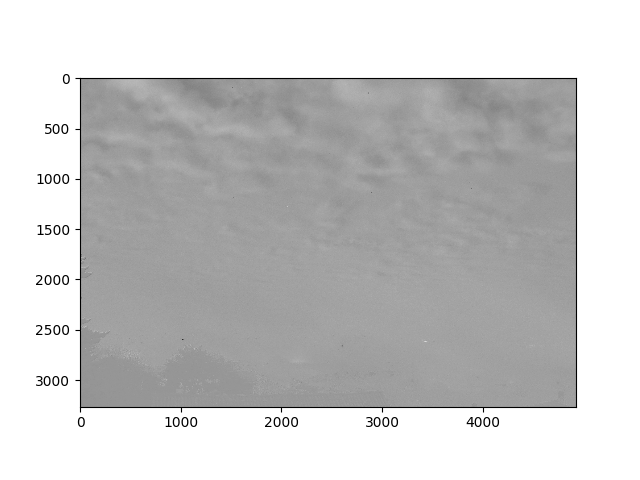

In [9]:
fig,ax=subplots()
ax.imshow(d, cmap="gray")

In [10]:
c1 = lab1_d.get()[...,0].ravel()
c0 = lab0_d.get()[...,0].ravel()
# fig, ax = subplots()
# ax.scatter(c0, c1, marker=".")

In [11]:
from scipy.stats import linregress
linregress(c0, c1)

LinregressResult(slope=1.0764701752781667, intercept=2.973748741678296, rvalue=0.978589723477801, pvalue=0.0, stderr=5.645208231345933e-05)

In [12]:
# m=d.mean()
# s=d.std()
# o = abs(d-m)/s
# o[(o>3)]=numpy.NAN
# fig,ax = subplots()
# ax.imshow(o)

In [12]:
e4 = Lab_to_sRGB(queue, (shape[1], shape[0]), None, 
                     lab0_d.data, srgb2_d.data, numpy.int32(shape[1]), numpy.int32(shape[0]))
e4.wait()
#print(srgb_d)
abs(srgb2_d.get()-raw.astype(int)).max()

0

# Implementation of linear regression on GPU

pre-requeist for the sigma-clipping

In [13]:
rk1 = ReductionKernel(ctx, dtype_out="float32", neutral=0, reduce_expr="a+b", map_expr="x[i]", 
                      arguments="__global float *x", name="simple_sum_kernel", )
arguments = ("__global float *value",)
float2 = pyopencl.tools.get_or_register_dtype("float2")
map_expr = "isfinite(value[i]) ? (float2)(value[i], 1.0f) : (float2)(0.0f, 0.0f)"
reduce_expr = "a+b"
neutral = "(float2)(0.0f,0.0f)"
#output_statement = "value[i] = item.s0; index[i+1] = item.s1;"
rk2 = ReductionKernel(ctx, dtype_out=float2, neutral=neutral, reduce_expr=reduce_expr, 
                      map_expr=map_expr, 
                      arguments=arguments, 
                      name="counter_sum_kernel", )
sum1 = ReductionKernel(ctx, 
                       dtype_out=pyopencl.tools.get_or_register_dtype("float2"), 
                       neutral="(float2)(0.0f, 0.0f)",
                       reduce_expr=reduce_expr, 
                       map_expr="mask[i] ? (float2)(0.0f, 0.0f) : (float2)(value[i], 1.0f)", 
                       arguments=("__global float *value", "__global char *mask"), 
                       name="sum_with_mask_kernel")
sum2 = ReductionKernel(ctx, 
                       dtype_out=pyopencl.tools.get_or_register_dtype("float4"), 
                       neutral="(float4)(0.0f, 0.0f, 0.0f, 0.0f)",
                       reduce_expr=reduce_expr, 
                       map_expr="mask[i] ?(float4)(0.0f, 0.0f, 0.0f, 0.0f):(float4)(x[i], y[i], 1.0f, 0.0f)", 
                       arguments=("__global float *x","__global float *y","__global char *mask"), 
                       name="double_sum_kernel")
sum3 = ReductionKernel(ctx, 
                       dtype_out=pyopencl.tools.get_or_register_dtype("float4"), 
                       neutral="(float4)(0.0f, 0.0f, 0.0f, 0.0f)",
                       reduce_expr=reduce_expr, 
                       map_expr="mask[i] ? (float4)(0.0f, 0.0f, 0.0f, 0.0f): (float4)(value[i].s0, value[i].s1, value[i].s2, 1.0f) ", 
                       arguments=("__global float4 *value","__global char *mask"), 
                       name="triple_sum_kernel")

In [14]:

def sigma_clip_np(img0, img1, cutof=3):
    data0 = img0.ravel()
    data1 = img1.ravel()
    size = data1.size
    cutof *= numpy.sqrt(size)
    mask = numpy.zeros(size, bool)

    first_size = current_size = 0
    last_size = -1

    while last_size<current_size:
        last_size = current_size
        nask = numpy.logical_not(mask)
        reg = linregress(data0[nask], data1[nask])
        mask = numpy.logical_or(mask,abs(data0*reg.slope+reg.intercept-data1)>(cutof*reg.stderr))
        current_size = mask.sum()
        print(reg, current_size)
    print(first_size, current_size)
    return reg, mask

In [15]:
reg, mask = sigma_clip_np(c0, c1, 100)

LinregressResult(slope=1.0764701752781667, intercept=2.973748741678296, rvalue=0.978589723477801, pvalue=0.0, stderr=5.645208231345933e-05) 434
LinregressResult(slope=1.0766916472084704, intercept=2.9687292339186833, rvalue=0.9787147353146489, pvalue=0.0, stderr=5.6293959952939e-05) 437
LinregressResult(slope=1.0766918004177417, intercept=2.968734530796489, rvalue=0.9787150646937482, pvalue=0.0, stderr=5.629352339077168e-05) 437
0 437


In [16]:
print(c0.sum(), c1.sum())

383108540.0 460237660.0


In [17]:
pyopencl.tools.get_or_register_dtype("float4")

dtype([(('x', 's0'), '<f4'), (('y', 's1'), '<f4'), (('z', 's2'), '<f4'), (('w', 's3'), '<f4')])

In [18]:
def linregress_cl(data0, data1):
    if isinstance(data0, gpuarray.Array):
        data0_d = data0
    else:
        data0_d = gpuarray.to_device(queue, data0)
    if isinstance(data1, gpuarray.Array):
        data1_d = data1
    else:
        data1_d = gpuarray.to_device(queue, data1)
    size = data0.size
    mask_d = gpuarray.zeros(queue, size, "int8")
    var2_d = gpuarray.zeros(queue, size, pyopencl.tools.get_or_register_dtype("float4"))
    err2_d = gpuarray.zeros(queue, size, "float32")
    sumxy_d, evt1 = sum2(data0_d, data1_d, mask_d, return_event=True)
    #evt1.wait()
    evt2 = linreg_stage1(queue, (shape[1], shape[0]), None, 
                         data0_d.data,
                         data1_d.data,
                         sumxy_d.data,
                         var2_d.data,
                         numpy.int32(shape[1]), numpy.int32(shape[0]))
    #evt2.wait()
    sumvar_d, evt3 = sum3(var2_d, mask_d, wait_for=[evt2], return_event=True)
    #evt3.wait()
    evt4 = linreg_stage2(queue, (shape[1], shape[0]), None, 
                        data0_d.data,
                        data1_d.data,
                        sumxy_d.data,
                        sumvar_d.data,
                        err2_d.data,
                        numpy.int32(shape[1]), numpy.int32(shape[0]))
    evt4.wait()
    variance_d = sum1(err2_d, mask_d)
    
    sumxy = sumxy_d.get()
    
    mean_x = sumxy["s0"] / sumxy["s2"];
    mean_y = sumxy["s1"] / sumxy["s2"];
    
    sumvar = sumvar_d.get()
    
    slope = sumvar["s2"]/sumvar["s0"]
    intercept = mean_y - slope*mean_x
    R = sumxy["s2"]/numpy.sqrt(sumxy["s0"]*sumxy["s1"])
    
    variance = variance_d.get()
    print(variance)
    std = numpy.sqrt(variance["s0"]/(variance["s1"]-2.0))
    

    return (slope, intercept, R, std)
linregress_cl(c0, c1)

(96540104., 16084992.)


(1.0764701, 2.9737682, 0.038306184, 2.449872504580765)

In [48]:
linregress(c0, c1)

LinregressResult(slope=1.0544769064059347, intercept=0.2007971644761355, rvalue=0.9764060395878557, pvalue=0.0, stderr=5.814799274251895e-05)

In [19]:
mask_d = gpuarray.zeros(queue, shape[:2], "int8")
var2_d = gpuarray.zeros(queue, shape[:2], pyopencl.tools.get_or_register_dtype("float4"))
err2_d = gpuarray.zeros(queue, shape[:2], "float32")
Lum0_d = gpuarray.zeros(queue, shape[:2], "float32")
Lum1_d = gpuarray.zeros(queue, shape[:2], "float32")

def sigma_clip_cl(data0, data1, cutof=3):
    if isinstance(data0, gpuarray.Array):
        evt0 = LAB_2_Lum(queue, (shape[1], shape[0]), (64,8),
                          data0.data,
                          Lum0_d.data,
                          numpy.int32(shape[1]), numpy.int32(shape[0]))
    else:
        Lum0_d.set(numpy.ascontiguousarray(data0[...,0], "float32"))
    if isinstance(data1, gpuarray.Array):
        evt1 = LAB_2_Lum(queue, (shape[1], shape[0]), (64,8),
                          data1.data,
                          Lum1_d.data,
                          numpy.int32(shape[1]), numpy.int32(shape[0]))
    else:
        Lum1_d.set(numpy.ascontiguousarray(data1[...,0], "float32"))
    mask_d.fill(0)
    sumxy_d, evt7 = sum2(Lum0_d, Lum1_d, mask_d, return_event=True)
    sumxy = sumxy_d.get()
    first_size = current_size = sumxy["s2"]
    last_size = current_size +1
    while last_size>current_size:
        last_size = current_size
        evt2 = linreg_stage1(queue, (shape[1], shape[0]), (64,8), 
                             Lum0_d.data,
                             Lum1_d.data,
                             sumxy_d.data,
                             var2_d.data,
                             numpy.int32(shape[1]), numpy.int32(shape[0]))

        sumvar_d, evt3 = sum3(var2_d, mask_d, wait_for=[evt2], return_event=True)
        evt4 = linreg_stage2(queue, (shape[1], shape[0]), (64,8), 
                            Lum0_d.data,
                            Lum1_d.data,
                            sumxy_d.data,
                            sumvar_d.data,
                            err2_d.data,
                            numpy.int32(shape[1]), numpy.int32(shape[0]))
        
        variance_d, ev5 = sum1(err2_d, mask_d, wait_for=[evt4], return_event=True)
        evt6 = linreg_clip(queue, (shape[1], shape[0]), (64,8), 
                        Lum0_d.data,
                        Lum1_d.data,
                        sumxy_d.data,
                        sumvar_d.data,
                        variance_d.data,
                        numpy.float32(cutof),          
                        mask_d.data,
                        numpy.int32(shape[1]), numpy.int32(shape[0]))
        sumxy_d, evt7 = sum2(Lum0_d, Lum1_d, mask_d, wait_for=[evt6], return_event=True)
        sumxy = sumxy_d.get()
        current_size = sumxy["s2"]
        #print(current_size)
        
        
    mean_x = sumxy["s0"] / sumxy["s2"];
    mean_y = sumxy["s1"] / sumxy["s2"];
    
    sumvar = sumvar_d.get()
    
    slope = sumvar["s2"]/sumvar["s0"]
    intercept = mean_y - slope*mean_x
    R = sumxy["s2"]/numpy.sqrt(sumxy["s0"]*sumxy["s1"])
    
    variance = variance_d.get()
    std = numpy.sqrt(variance["s0"]/(variance["s1"]-2.0))
    #print(first_size, current_size)
    return  (slope, intercept, R, std, float(current_size))

In [20]:
%%time 
sigma_clip_cl(lab0_d, lab1_d, 3)

CPU times: user 192 ms, sys: 88 ms, total: 280 ms
Wall time: 277 ms


(1.087966, 2.7265568, 0.03807659, 1.9989759927077007, 15567353.0)

<IPython.core.display.Javascript object>


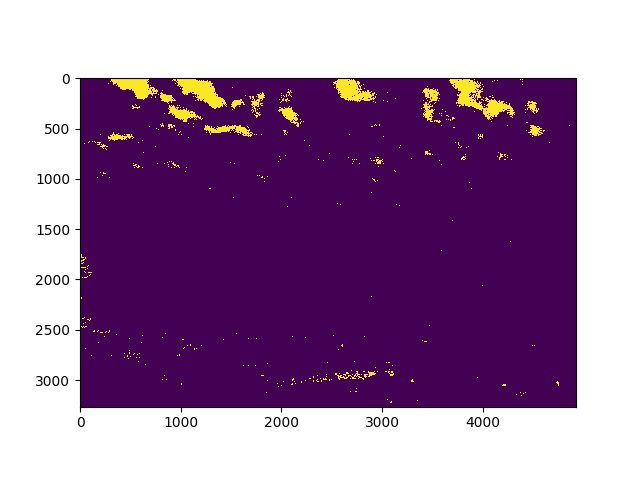

In [21]:
fig,ax = subplots()
ax.imshow(mask_d.get())


In [22]:
from scipy.stats import linregress
linregress(c0, c1)

LinregressResult(slope=1.0764701752781667, intercept=2.973748741678296, rvalue=0.978589723477801, pvalue=0.0, stderr=5.645208231345933e-05)

# Measurement of the flickering

In [23]:
default = (1,0,1,0,0)
delta_L = {images[0]: default}
results = [default]
current = images[0]
srgb0_d.set(numpy.asarray(Image.open(current)))
e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb0_d.data, lab0_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))

for img in images[1:]:
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e2 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    m = sigma_clip_cl(lab0_d, lab1_d)
    print(os.path.basename(img), m)
    results.append(m)
    delta_L[img]=m

    srgb0_d, srgb1_d = srgb1_d, srgb0_d
    lab0_d, lab1_d = lab1_d, lab0_d


06h22m11-NIKON_D5100.jpg (0.73968244, 9.032655, 0.09391225, 7.468645862881826, 15641711.0)
06h22m35-NIKON_D5100.jpg (0.9949771, 1.5033331, 0.064735204, 2.160565560009582, 14825389.0)
06h22m56-NIKON_D5100.jpg (0.77086174, 3.3879013, 0.058183424, 2.717197577054327, 14324829.0)
06h23m51-NIKON_D5100.jpg (0.9004133, -1.0784702, 0.059371274, 2.1200879442492266, 15639719.0)
06h24m37-NIKON_D5100.jpg (1.2835048, 25.484472, 0.036202203, 4.515883596519388, 14823743.0)
06h25m07-NIKON_D5100.jpg (0.686775, -7.7302933, 0.031852033, 4.112203360152896, 15924917.0)
06h25m54-NIKON_D5100.jpg (0.9257592, 2.5247364, 0.04285114, 2.6127317752802077, 15570407.0)
06h26m09-NIKON_D5100.jpg (1.0175388, -0.2946682, 0.04186661, 2.22067937001146, 15308503.0)
06h26m24-NIKON_D5100.jpg (0.97445613, -0.080394745, 0.04253504, 2.1386587023184753, 15455639.0)
06h26m39-NIKON_D5100.jpg (0.9883335, 0.7993965, 0.042640217, 2.1098575501296217, 15492851.0)
06h26m54-NIKON_D5100.jpg (1.0449852, 2.855198, 0.03919654, 2.1906254551078

06h46m39-NIKON_D5100.jpg (1.0039486, 0.7925148, 0.041760873, 1.3581784543346744, 15880231.0)
06h46m54-NIKON_D5100.jpg (0.987132, -0.21884537, 0.041436773, 1.2559409531942567, 15952897.0)
06h47m09-NIKON_D5100.jpg (1.0848149, 1.5581818, 0.039209176, 1.6800158729220553, 16014141.0)
06h47m24-NIKON_D5100.jpg (0.8426445, -1.5254402, 0.04175351, 1.4034185141098323, 15875149.0)
06h47m39-NIKON_D5100.jpg (1.0106455, 1.160181, 0.044803597, 1.398526086415712, 15988159.0)
06h47m54-NIKON_D5100.jpg (1.0333058, 0.21910286, 0.042561814, 1.3827972777223188, 15932756.0)
06h48m09-NIKON_D5100.jpg (1.0003992, 0.7075577, 0.04102363, 1.5292696886093295, 15972906.0)
06h48m24-NIKON_D5100.jpg (0.95926976, -0.35243797, 0.041661695, 1.3305922657734808, 15956087.0)
06h48m39-NIKON_D5100.jpg (0.98031974, 0.23797035, 0.042987246, 1.2260049121573666, 15942291.0)
06h48m54-NIKON_D5100.jpg (1.0075569, 0.78123665, 0.042344257, 1.2320879812882035, 15929595.0)
06h49m09-NIKON_D5100.jpg (0.9955788, 0.83825684, 0.04089208, 1.31

07h08m39-NIKON_D5100.jpg (0.9886185, -0.0479908, 0.041117452, 1.1573152098955208, 15965056.0)
07h08m54-NIKON_D5100.jpg (1.008045, 0.67124176, 0.04066862, 1.1168046879888027, 15964013.0)
07h09m09-NIKON_D5100.jpg (0.98620903, -0.6729374, 0.040830165, 1.070637719222999, 15968224.0)
07h09m24-NIKON_D5100.jpg (0.98040575, -0.46647263, 0.042640958, 1.10170138572996, 15946845.0)
07h09m39-NIKON_D5100.jpg (1.0033709, 0.26704025, 0.04321682, 1.1534456090076228, 15876764.0)
07h09m54-NIKON_D5100.jpg (1.0159404, 0.879467, 0.041737814, 1.205432292278995, 15951916.0)
07h10m09-NIKON_D5100.jpg (0.98163724, 0.0024662018, 0.04100762, 1.078991152075025, 15983436.0)
07h10m24-NIKON_D5100.jpg (1.0142769, 0.22636986, 0.040897883, 1.085103069699728, 15976622.0)
07h10m39-NIKON_D5100.jpg (0.9635951, -0.589798, 0.04178638, 0.9892685883457222, 15963953.0)
07h10m54-NIKON_D5100.jpg (1.0121721, 0.054525375, 0.042696692, 1.0769066977504005, 15975920.0)
07h11m09-NIKON_D5100.jpg (0.96975017, -0.43401527, 0.043546338, 1.0

07h30m39-NIKON_D5100.jpg (1.0208584, 0.51384544, 0.04022016, 1.0647840876497778, 15922841.0)
07h30m54-NIKON_D5100.jpg (1.0491714, 0.8307991, 0.037937287, 1.0892965385984346, 15953578.0)
07h31m09-NIKON_D5100.jpg (0.96174544, -1.9048195, 0.03853077, 1.2791675025529952, 15945852.0)
07h31m24-NIKON_D5100.jpg (0.94335896, -0.75836563, 0.043151647, 1.1749988789436492, 15641839.0)
07h31m39-NIKON_D5100.jpg (1.041413, 0.6501293, 0.04341579, 1.0512434357041278, 15907747.0)
07h31m54-NIKON_D5100.jpg (0.98445755, 0.5935421, 0.041748066, 1.1846050913345734, 15856394.0)
07h32m09-NIKON_D5100.jpg (0.9074725, 0.3537674, 0.044091146, 1.20196695224131, 15681549.0)
07h32m24-NIKON_D5100.jpg (1.0108724, 1.2124519, 0.043786604, 1.174119707692353, 15872044.0)
07h32m39-NIKON_D5100.jpg (0.9642492, 0.1919651, 0.04306194, 1.078821781151745, 15884401.0)
07h32m54-NIKON_D5100.jpg (0.99218965, 0.9959526, 0.042784434, 1.0912887280647692, 15909497.0)
07h33m09-NIKON_D5100.jpg (0.96526855, 0.33804512, 0.04233763, 1.2044724

07h52m39-NIKON_D5100.jpg (0.94778264, -0.76773834, 0.043380525, 1.1496609842786278, 15860393.0)
07h52m54-NIKON_D5100.jpg (1.0339755, 1.4159069, 0.042997137, 1.3892746864647352, 15983589.0)
07h53m09-NIKON_D5100.jpg (0.95396537, -0.08981323, 0.042165156, 1.2291803472425602, 15941871.0)
07h53m24-NIKON_D5100.jpg (1.0102655, 1.1256695, 0.041903462, 1.257101436497903, 15933407.0)
07h53m39-NIKON_D5100.jpg (1.0136877, 0.5743351, 0.0399898, 1.1109698523744465, 15920344.0)
07h53m54-NIKON_D5100.jpg (0.91766304, -0.954607, 0.042120617, 1.077824755334291, 15887160.0)
07h54m09-NIKON_D5100.jpg (1.0226643, 0.38217354, 0.04369711, 1.1181711048542329, 15974186.0)
07h54m24-NIKON_D5100.jpg (1.0224029, 0.49653244, 0.041919097, 1.2271880243247493, 15969094.0)
07h54m39-NIKON_D5100.jpg (0.98245937, 0.4696312, 0.041187625, 1.1858721096666471, 15709065.0)
07h54m54-NIKON_D5100.jpg (0.98959565, 0.29006767, 0.041150194, 1.075151663741085, 15901121.0)
07h55m09-NIKON_D5100.jpg (1.0093578, 0.07561302, 0.04079559, 1.2

08h14m39-NIKON_D5100.jpg (1.021788, -0.1444397, 0.046457246, 1.271654854323237, 15641796.0)
08h14m54-NIKON_D5100.jpg (0.99234366, -0.35860252, 0.046762813, 1.242210282513518, 15646522.0)
08h15m09-NIKON_D5100.jpg (1.0212616, 0.06416893, 0.046879664, 1.2446441631538427, 15635893.0)
08h15m24-NIKON_D5100.jpg (1.003027, -0.2112236, 0.046583712, 1.2252458391940286, 15630623.0)
08h15m39-NIKON_D5100.jpg (0.9919709, -0.2714939, 0.047387887, 1.2059675043872016, 15625108.0)
08h15m54-NIKON_D5100.jpg (0.995994, 0.14061737, 0.04796364, 1.1738567156016202, 15616302.0)
08h16m09-NIKON_D5100.jpg (0.98018026, 0.0058021545, 0.04848257, 1.1586838166391566, 15622388.0)
08h16m24-NIKON_D5100.jpg (1.0244261, 0.14777565, 0.048306283, 1.1947211139776173, 15647891.0)
08h16m39-NIKON_D5100.jpg (1.0180866, 0.2175579, 0.046963576, 1.208020079171668, 15670581.0)
08h16m54-NIKON_D5100.jpg (0.9817779, -0.045930862, 0.04686404, 1.1763070753662475, 15678217.0)
08h17m09-NIKON_D5100.jpg (1.0012197, 0.0417881, 0.047371477, 1.

08h36m39-NIKON_D5100.jpg (1.0209943, 0.008081436, 0.06012797, 0.9206718879540319, 14989605.0)
08h36m54-NIKON_D5100.jpg (0.9552594, -0.1596098, 0.061715964, 0.8989496580840874, 14821552.0)
08h37m09-NIKON_D5100.jpg (1.0004997, -0.03271675, 0.06371821, 0.8797307922292495, 14733527.0)
08h37m24-NIKON_D5100.jpg (0.9273559, -0.11458206, 0.06674661, 0.8030885100296025, 14670268.0)
08h37m39-NIKON_D5100.jpg (1.01732, 0.09671211, 0.068281904, 0.798591467502992, 14737734.0)
08h37m54-NIKON_D5100.jpg (1.0116224, 0.14807796, 0.06665612, 0.7921895412148934, 14751817.0)
08h38m09-NIKON_D5100.jpg (1.0103933, 0.18604565, 0.06501214, 0.7839968987093593, 14813719.0)
08h38m24-NIKON_D5100.jpg (1.0163164, 0.2202301, 0.06333201, 0.7831207833219785, 14815713.0)
08h38m39-NIKON_D5100.jpg (0.97588044, 0.2727871, 0.062327895, 0.783982737788999, 14936785.0)
08h38m54-NIKON_D5100.jpg (1.043272, 0.464859, 0.06024123, 0.8446972451450879, 15054160.0)
08h39m09-NIKON_D5100.jpg (0.96919537, 0.36750793, 0.058547873, 0.7931628

08h58m39-NIKON_D5100.jpg (0.98550236, -0.047777176, 0.07232209, 0.6389132512557056, 12503110.0)
08h58m54-NIKON_D5100.jpg (1.0126876, -0.025805473, 0.07351471, 0.6279707145705659, 12440479.0)
08h59m09-NIKON_D5100.jpg (1.0041782, 0.14710236, 0.07205278, 0.6458430528925174, 12488928.0)
08h59m24-NIKON_D5100.jpg (0.99358267, -0.0530653, 0.07226222, 0.6376474310457946, 12464823.0)
08h59m39-NIKON_D5100.jpg (1.0298716, -0.13105679, 0.07270534, 0.6641282129599442, 12520390.0)
08h59m54-NIKON_D5100.jpg (0.9990152, 0.13445663, 0.072065674, 0.6589242751550571, 12594390.0)
09h00m09-NIKON_D5100.jpg (1.0036278, 0.06757355, 0.07206954, 0.6315020255863935, 12617497.0)
09h00m24-NIKON_D5100.jpg (0.98577887, -0.09789944, 0.07307909, 0.6397770018724562, 12763067.0)
09h00m39-NIKON_D5100.jpg (0.9929407, 0.35149193, 0.07399825, 0.6552158338564378, 12950474.0)
09h00m54-NIKON_D5100.jpg (0.993939, 0.09913635, 0.073900044, 0.5901072376377117, 12901310.0)
09h01m09-NIKON_D5100.jpg (0.99075985, 0.07495785, 0.07503946

09h20m39-NIKON_D5100.jpg (1.1392821, 0.40292072, 0.08829933, 0.8012259376817721, 14427039.0)
09h20m54-NIKON_D5100.jpg (1.1190971, 0.44480038, 0.07512266, 0.7689337007845307, 14324189.0)
09h21m09-NIKON_D5100.jpg (1.1004831, 0.058410645, 0.06647665, 0.818595914694052, 14247588.0)
09h21m24-NIKON_D5100.jpg (1.0030949, -0.16942883, 0.063576795, 0.8249805456521375, 14199749.0)
09h21m39-NIKON_D5100.jpg (0.97106063, -0.14393711, 0.06551784, 0.7939466232868292, 14238873.0)
09h21m54-NIKON_D5100.jpg (1.0332811, 0.35365677, 0.065357886, 0.8433181815783702, 14369588.0)
09h22m09-NIKON_D5100.jpg (0.962311, -0.047117233, 0.06580104, 0.7462303515303516, 14181944.0)
09h22m24-NIKON_D5100.jpg (0.94509506, -0.34091473, 0.07025897, 0.8050504341589302, 14145409.0)
09h22m39-NIKON_D5100.jpg (0.8809197, -0.3724947, 0.07931835, 0.7541918594912804, 14033705.0)
09h22m54-NIKON_D5100.jpg (1.0274838, 0.3637066, 0.0838684, 0.746838367044942, 13857930.0)
09h23m09-NIKON_D5100.jpg (1.1606332, 0.69260406, 0.07437328, 0.93

09h42m39-NIKON_D5100.jpg (1.0085644, -0.08132362, 0.035219986, 1.298515702556776, 15272583.0)
09h42m54-NIKON_D5100.jpg (1.0375675, 0.47708702, 0.034303926, 1.352229615019067, 15300582.0)
09h43m09-NIKON_D5100.jpg (0.99809176, -0.37046432, 0.03374135, 1.3518993067477907, 15313575.0)
09h43m24-NIKON_D5100.jpg (0.9333688, -1.0877285, 0.035947315, 1.3672525939212699, 15393209.0)
09h43m39-NIKON_D5100.jpg (0.9978198, -0.29350471, 0.038518418, 1.2950704302213045, 15250526.0)
09h43m54-NIKON_D5100.jpg (1.0083885, -0.12338066, 0.038876142, 1.288988053284665, 15246893.0)
09h44m09-NIKON_D5100.jpg (1.0086229, -0.04417038, 0.038837373, 1.2681464112999696, 15242847.0)
09h44m24-NIKON_D5100.jpg (1.0027224, 0.103336334, 0.038735002, 1.252214248845996, 15243131.0)
09h44m39-NIKON_D5100.jpg (0.9947581, -0.21835518, 0.03901704, 1.2382913225479983, 15241405.0)
09h44m54-NIKON_D5100.jpg (1.0059057, -0.06729889, 0.03927743, 1.2795445660845597, 15297275.0)
09h45m09-NIKON_D5100.jpg (1.0221243, 0.1172142, 0.03879604

6086005.393196792


<IPython.core.display.Javascript object>


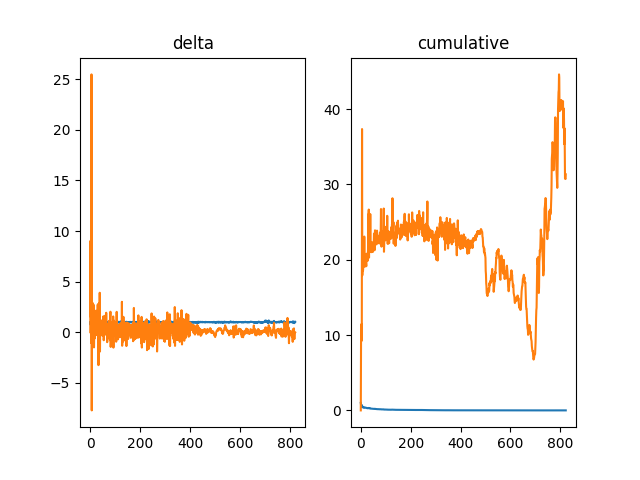

Text(0.5,1,'cumulative')

In [24]:
print(numpy.std(results))
fig,ax = subplots(1,2)
ax[0].plot([i[0] for i in results], label="raw slope")
ax[0].plot([i[1] for i in results], label="raw intercept")

cumul = []
cur = (1,0)
for res in results:
    cur = (cur[0]*res[0], res[1] + res[0]*cur[1])
    cumul.append(cur)
# cs = numpy.cumsum(results)
# from scipy.ndimage import gaussian_filter1d
# smooth = gaussian_filter1d(cs, 15)
ax[1].plot([i[0] for i in cumul], label="measured slope")
ax[1].plot([i[1] for i in cumul], label="measured intercept")
# ax[1].plot(smooth,label="smoothed")
# ax[0].plot(cs-smooth, label="delta_smooth")
# ax[0].legend()
ax[0].set_title("delta")
ax[1].set_title("cumulative")

<IPython.core.display.Javascript object>


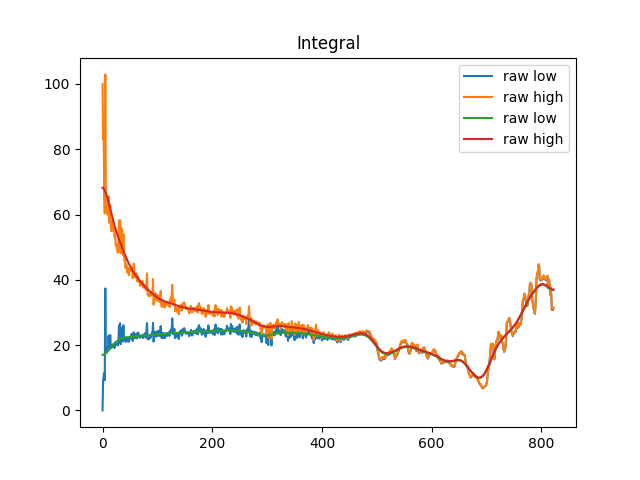

In [25]:
from scipy.ndimage.filters import gaussian_filter1d
sigma = 12

fig,ax = subplots(1,1)
raw_low = [i[1] for i in cumul]
raw_high = [i[0]*100+i[1] for i in cumul]
ax.plot(raw_low, label="raw low")
ax.plot(raw_high, label="raw high")

smooth_low = gaussian_filter1d(raw_low, sigma)
smooth_high = gaussian_filter1d(raw_high, sigma)
ax.plot(smooth_low, label="raw low")
ax.plot(smooth_high, label="raw high")


ax.set_title("Integral")
ax.legend()


<IPython.core.display.Javascript object>


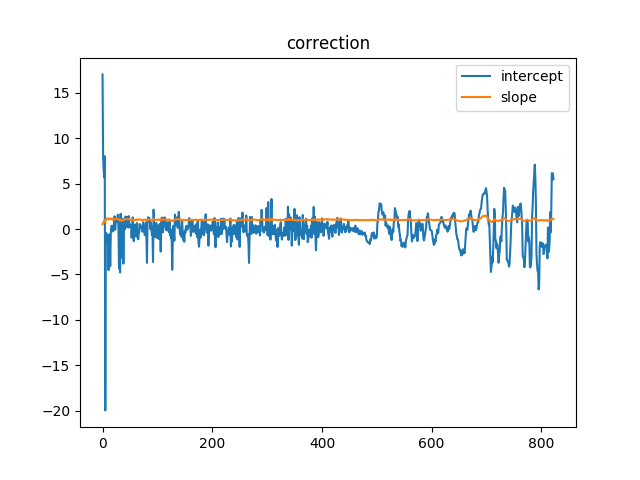

In [26]:
correct_intercept =  smooth_low - raw_low
correct_slope =  (smooth_high-smooth_low)/(numpy.asarray(raw_high)-raw_low)
fig,ax = subplots(1,1)
ax.plot(correct_intercept, label="intercept")
ax.plot(correct_slope, label="slope")


ax.set_title("correction")
ax.legend()


# Corrections 

In [27]:
target = os.path.join(source, "deflickv2_scaled")
if not os.path.isdir(target):
    os.makedirs(target)

In [28]:
%%time
HD = (1080, 1920, 3)
srgb_HD_d = gpuarray.empty(queue, HD, "uint8")
lab_HD_d = gpuarray.empty(queue, HD, "float32")
for img, cor0, cor1, offset_y in zip(images, correct_intercept, correct_slope, linspace(492,0,len(images))):
    srgb1_d.set(numpy.asarray(Image.open(img)))
    e1 = sRGB_to_Lab(queue, (shape[1], shape[0]), None, 
                   srgb1_d.data, lab1_d.data, 
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e2 = offset_LAB(queue, (shape[1], shape[0]), None, 
                   lab1_d.data, numpy.float32(cor0), numpy.float32(cor1),
                   numpy.int32(shape[1]), numpy.int32(shape[0]))
    e4 = decimate(queue, (HD[1], HD[0]), None,
                  lab1_d.data, lab_HD_d.data,
                  numpy.int32(shape[1]), numpy.int32(shape[0]),
                  numpy.int32(HD[1]), numpy.int32(HD[0]),
                  numpy.float32(0), numpy.float32(offset_y),
                  numpy.float32(2.566666666666667), numpy.float32(2.566666666666667),
                  numpy.int32(3),numpy.int32(0),
                 )
    e3 = Lab_to_sRGB(queue, (HD[1], HD[0]), None, 
                     lab_HD_d.data, srgb_HD_d.data, 
                     numpy.int32(HD[1]), numpy.int32(HD[0]))
    Image.fromarray(srgb_HD_d.get()).save(os.path.join(target, os.path.basename(img)))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
